In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt

from tensorflow.keras import models, layers, Input, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

from sklearn.feature_extraction.text import CountVectorizer

from Code.utils.dataset import Dataset

[nltk_data] Downloading package punkt to C:\Users\Guilherme
[nltk_data]     Barbosa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
def build_model(hp):
    min_hidden = 2
    max_hidden = 16

    model = models.Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

    hp1_units = hp.Int('hidden1_units', min_value=min_hidden, max_value=max_hidden, step=2)
    model.add(SimpleRNN(hp1_units, activation='sigmoid', return_sequences=True))

    hp2_units = hp.Int('hidden2_units', min_value=min_hidden, max_value=max_hidden, step=2)
    model.add(SimpleRNN(hp2_units, activation='sigmoid'))

    model.add(Dense(1, activation='sigmoid'))

    #compilar modelo
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.005, 0.01])
    hp_momentum = hp.Choice('momentum', values=[0.001, 0.005, 0.01])
    optimizer = SGD(learning_rate=hp_learning_rate, momentum=hp_momentum)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    return model

In [17]:
# Load datasets

dataset = Dataset('../../Dataset/DatasetsGerados/dataset_training_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_training_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_test_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_test_output.csv')

# Remover pontuação deu pior resultado
X_train, y_train, X_validation, y_validation, X_test, y_test, ids = dataset.get_dataset_embedding('Text', 'Label', sep='\t', rem_punctuation=False)

In [19]:
# Start tuner

tuner = kt.Hyperband(
    build_model,
    objective='acc',
    max_epochs=10,
    factor=3,
    directory='./KerasTuner',  # Directory to store results
    project_name='RNN_Tuning_2_Layers'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

Trial 30 Complete [00h 00m 28s]
acc: 0.5090000033378601

Best acc So Far: 0.671999990940094
Total elapsed time: 00h 07m 33s


Hidden Layer 1 has 16 units
Hidden Layer 2 has 14 units
Optimizer learning rate = 0.01
Optimizer momentum = 0.001
Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - acc: 0.4994 - loss: 0.8122 - val_acc: 0.4990 - val_loss: 0.6943
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - acc: 0.5018 - loss: 0.6942 - val_acc: 0.5220 - val_loss: 0.6920
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - acc: 0.5306 - loss: 0.6919 - val_acc: 0.5490 - val_loss: 0.6902
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - acc: 0.5489 - loss: 0.6895 - val_acc: 0.5280 - val_loss: 0.6891
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - acc: 0.5675 - loss: 0.6889 - val_acc: 0.6010 - val_loss: 0.6874
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - acc: 0.5991 - loss: 0.6878 - val_acc: 0.6200 - val_loss: 0.6860
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - acc: 0.6073 - loss: 0.6854 - val_acc: 0.6180 - val_loss: 0.6844
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step 

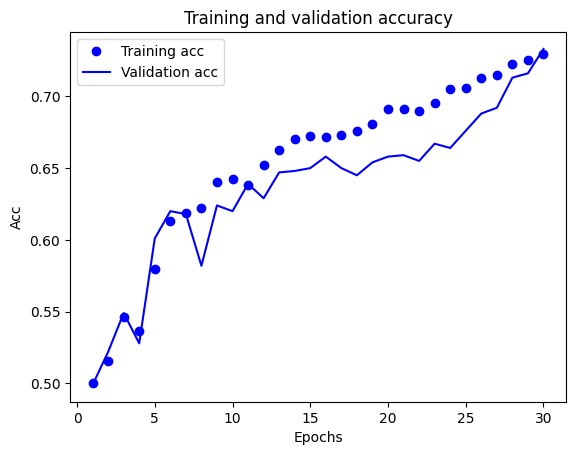

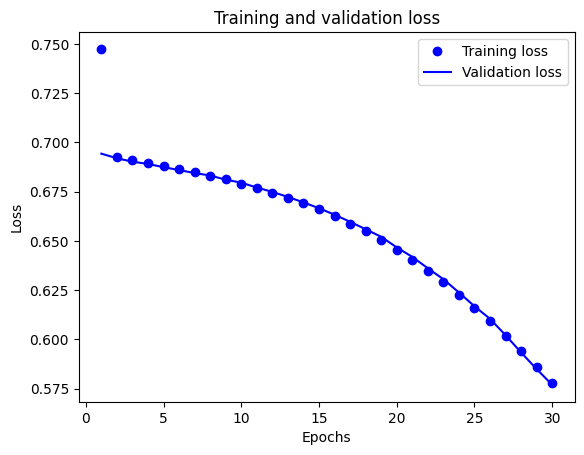

[0.5841003060340881, 0.7239999771118164]

In [25]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

n_features = X_train.shape[1]

hidden1_units = best_hps['hidden1_units']
hidden2_units = best_hps['hidden2_units']
learning_rate = best_hps['learning_rate']
momentum = best_hps['momentum']

print(f"Hidden Layer 1 has {hidden1_units} units")
print(f"Hidden Layer 2 has {hidden2_units} units")
print(f"Optimizer learning rate = {learning_rate}")
print(f"Optimizer momentum = {momentum}")

model = models.Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(SimpleRNN(hidden1_units, activation='sigmoid', return_sequences=True))
model.add(SimpleRNN(hidden2_units, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

#compilar modelo
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

# Plot accuracy curves

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Plot loss curves

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Model
results = model.evaluate(X_test, y_test, verbose = 0)
results

In [28]:
# Predict test dataset

out = model.predict(X_test)

if y_test is not None:
    print(model.evaluate(X_test, y_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - acc: 0.5667 - loss: 0.6708
[0.670793354511261, 0.5666666626930237]


In [21]:
# Store results

results_filepath = './Results/rnn_tuner_2_layers_results.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(results_filepath), exist_ok=True)

results = dataset.merge_results(ids, out)
results.to_csv(results_filepath, sep='\t', index=False)

In [27]:
dataset.set_dataset_test('../../Dataset/dataset1_inputs.csv', '../../Dataset/dataset1_outputs.csv')

X_test, y_test, ids = dataset.get_test_dataset_embedding('Text', 'Label', sep='\t', rem_punctuation=False)